In [ ]:
#Initialize the kaggle and the dataset
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! touch kaggle.json | echo '{"username":"jundifathan","key":"d8ce5ff328ebb2f5dab22dc29dbd4546"}' > kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d rizwan123456789/potato-disease-leaf-datasetpld

100% 37.4M/37.4M [00:03<00:00, 18.6MB/s]
100% 37.4M/37.4M [00:03<00:00, 10.8MB/s]


In [ ]:
! unzip potato-disease-leaf-datasetpld.zip

Archive:  potato-disease-leaf-datasetpld.zip
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_1.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_10.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_100.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_101.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_102.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_103.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_104.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_105.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_106.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_107.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_108.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_109.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_

In [ ]:
!pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline
import tensorflow as tf
import keras
import glob
import cv2
import pickle, datetime

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import LSTM, Input, TimeDistributed,Convolution2D,Activation
from keras.layers.convolutional import ZeroPadding2D
from keras.optimizers import RMSprop, SGD
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing.image import array_to_img
from keras.models import load_model

from skimage.feature import local_binary_pattern
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os

In [ ]:
dir_val = "/content/PLD_3_Classes_256/Validation/*"
dir_tra = "/content/PLD_3_Classes_256/Training/*"

In [ ]:
#Create Training Model
train_leaves_images = []
train_leaves_labels = []
for directory_path in glob.glob(dir_tra):
    leaves_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (64,64))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        freq = np.fft.fftshift(np.fft.fft2(img))
        train_leaves_images.append(img)
        train_leaves_labels.append(leaves_label)
train_leaves_images = np.array(train_leaves_images)
train_leaves_labels = np.array(train_leaves_labels)

train_leaves_labels

array(['/content/PLD_3_Classes_256/Training/Late_Blight',
       '/content/PLD_3_Classes_256/Training/Late_Blight',
       '/content/PLD_3_Classes_256/Training/Late_Blight', ...,
       '/content/PLD_3_Classes_256/Training/Early_Blight',
       '/content/PLD_3_Classes_256/Training/Early_Blight',
       '/content/PLD_3_Classes_256/Training/Early_Blight'], dtype='<U48')

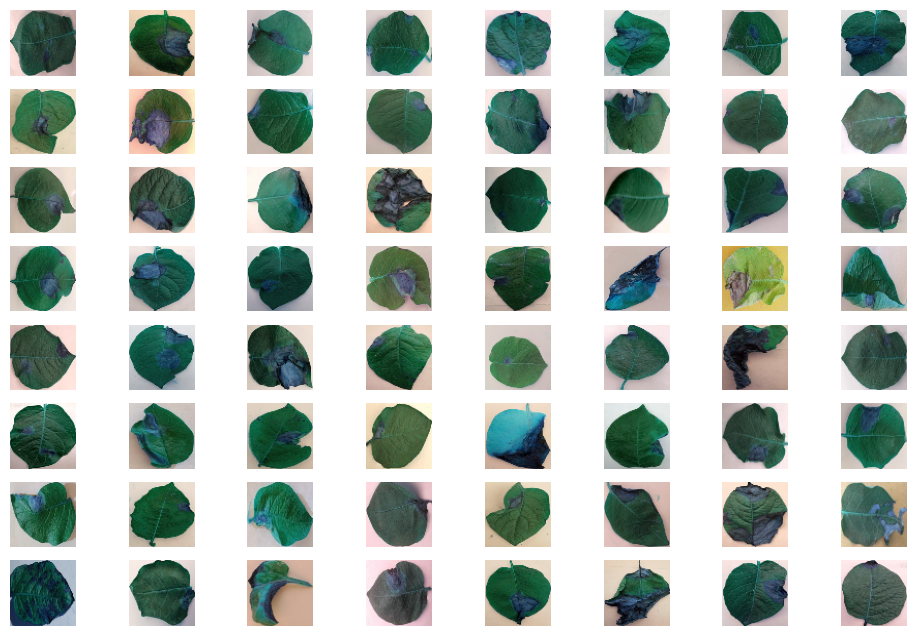

In [ ]:
num_images = 64

# Create a figure to display the images
fig = plt.figure(figsize=(12, 8))

# Loop through the first 'num_images' in the array
for i in range(num_images):
    # Get the preprocessed image from the array
    image = train_leaves_images[i]

    # Convert the image from grayscale to BGR
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Add the image to the figure
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(image_bgr)
    ax.axis('off')

# Show the figure
plt.show()

In [ ]:
label_to_id = {v:i for i,v in enumerate(np.unique(train_leaves_labels))}
id_to_label = {v: k for k, v in label_to_id.items()}
train_label_ids = np.array([label_to_id[x] for x in train_leaves_labels])

In [ ]:
train_leaves_images.shape, train_label_ids.shape, train_leaves_labels.shape

((3251, 64, 64, 3), (3251,), (3251,))

In [ ]:
# Create Testing Model
test_leaves_images = []
test_leaves_labels = []
for directory_path in glob.glob(dir_val):
    leaves_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (64,64))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        freq = np.fft.fftshift(np.fft.fft2(img))
        test_leaves_images.append(img)
        test_leaves_labels.append(leaves_label)
test_leaves_images = np.array(test_leaves_images)
test_leaves_labels = np.array(test_leaves_labels)

In [ ]:
label_to_ids = {v:i for i,v in enumerate(np.unique(test_leaves_labels))}
id_to_labels = {v: k for k, v in label_to_id.items()}
test_label_ids = np.array([label_to_ids[x] for x in test_leaves_labels])

In [ ]:
test_leaves_images.shape, test_label_ids.shape

((416, 64, 64, 3), (416,))

In [ ]:
x_train, y_train, x_test, y_test, N_CATEGORY =train_leaves_images,train_leaves_labels,test_leaves_images,test_leaves_labels,len(label_to_id)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, N_CATEGORY)

(3251, 64, 64, 3) (3251,) (416, 64, 64, 3) (416,) 3


In [ ]:
id_to_label

{0: '/content/PLD_3_Classes_256/Training/Early_Blight',
 1: '/content/PLD_3_Classes_256/Training/Healthy',
 2: '/content/PLD_3_Classes_256/Training/Late_Blight'}

In [ ]:
#Create the CNN Architecture
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def get_CNN(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [ ]:
CNN = get_CNN((64,64,3),N_CATEGORY)
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dropout_1 (Dropout)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               16777472  
                                                      

In [ ]:
#Normalization of the images and one-hot encoding of the labels
CNN.compile(loss='categorical_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])
X_normalized = np.array(x_train / 255.0 - 0.5 )
X_normalized_test = np.array(x_test / 255.0 - 0.5 )

label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train)
y_one_hot_test = label_binarizer.fit_transform(y_test)

Epoch 1/10
51/51 [==============================] - 119s 2s/step - loss: 1.7216 - accuracy: 0.5054 - val_loss: 0.8198 - val_accuracy: 0.6346
Epoch 2/10
51/51 [==============================] - 116s 2s/step - loss: 0.8273 - accuracy: 0.6453 - val_loss: 0.8510 - val_accuracy: 0.5841
Epoch 3/10
51/51 [==============================] - 116s 2s/step - loss: 0.6660 - accuracy: 0.7330 - val_loss: 0.5967 - val_accuracy: 0.7668
Epoch 4/10
51/51 [==============================] - 117s 2s/step - loss: 0.4791 - accuracy: 0.8093 - val_loss: 0.5399 - val_accuracy: 0.7861
Epoch 5/10
51/51 [==============================] - 118s 2s/step - loss: 0.4042 - accuracy: 0.8539 - val_loss: 0.4410 - val_accuracy: 0.8438
Epoch 6/10
51/51 [==============================] - 117s 2s/step - loss: 0.2868 - accuracy: 0.8936 - val_loss: 0.6061 - val_accuracy: 0.7812
Epoch 7/10
51/51 [==============================] - 118s 2s/step - loss: 0.2302 - accuracy: 0.9216 - val_loss: 0.4866 - val_accuracy: 0.8245
Epoch 8/10
51

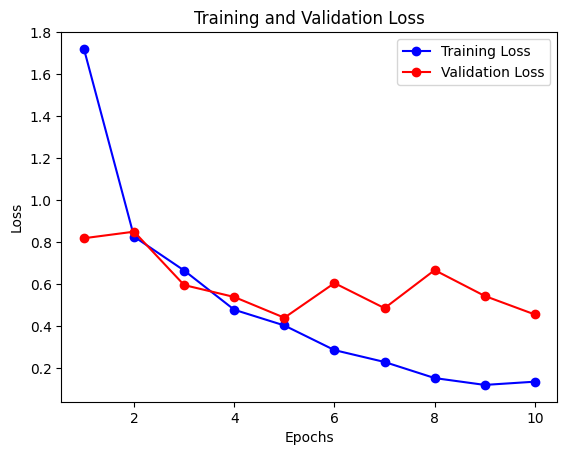

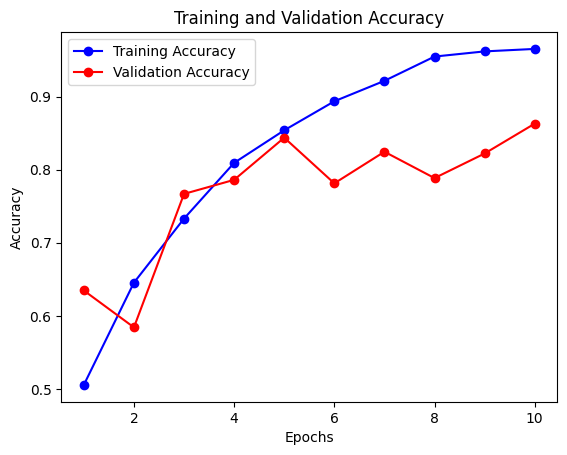

In [ ]:
import matplotlib.pyplot as plt

# Training the model and storing the history
Model_Train = CNN.fit(X_normalized, y_one_hot, batch_size=64, epochs=10, verbose=1,
                      validation_data=(X_normalized_test, y_one_hot_test))

# Retrieving the training and validation loss values
train_loss = Model_Train.history['loss']
val_loss = Model_Train.history['val_loss']

# Retrieving the training and validation accuracy values
train_accuracy = Model_Train.history['accuracy']
val_accuracy = Model_Train.history['val_accuracy']

# Plotting the training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, 'bo-', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

# Plotting the training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


1/1 [==============================] - 0s 275ms/step
['conv2d_2', 'conv2d_3', 'max_pooling2d_1', 'flatten_1', 'dropout_1', 'dense_2', 'dense_3']
(1, 64, 64, 64)
(1, 64, 64, 64)
(1, 32, 32, 64)


<ipython-input-45-e03b6c237254>:31: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


(1, 65536)
(1, 65536)
(1, 256)
(1, 3)


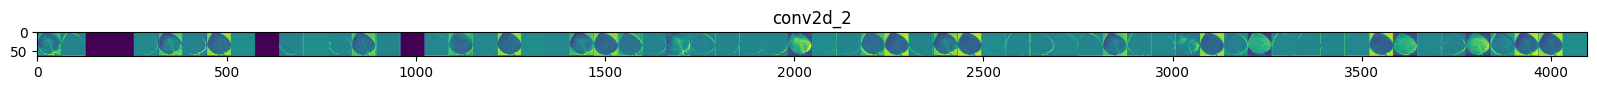

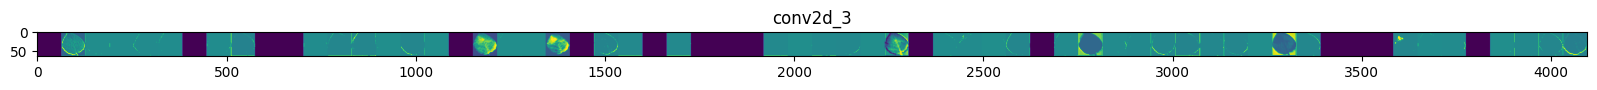

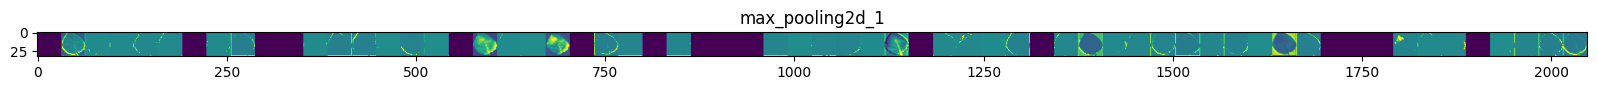

In [45]:
img_path='/content/PLD_3_Classes_256/Validation/Early_Blight/Early_Blight_1.jpg'

successive_outputs = [layer.output for layer in CNN.layers[0:]]

visualization_model = Model(inputs = CNN.input, outputs = successive_outputs)

img = load_img(img_path, target_size=(64, 64))

x   = img_to_array(img)
x   = x.reshape((1,) + x.shape)

x /= 255.0

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in CNN.layers]
print(layer_names)

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:

    n_features = feature_map.shape[-1]
    size       = feature_map.shape[ 1]

    display_grid = np.zeros((size, size * n_features))

    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [48]:
#Save the CNN model for the future use(as it takes hours to be trained!)
CNN.save('CNNleaf.h5')

In [49]:
#Pick the first Fully-Connected layer as the features which will be of dimension (1 x 256)
#Change the dense layer with the (1x256) feature, if not the code won't work
layer_name = 'dense_2'
FC_layer_model = Model(inputs=CNN.input,
                                 outputs=CNN.get_layer(layer_name).output)

In [50]:
#Find the Features for n number of train images and we will get n x 256
#This means we will get 256 features for each images.
i=0
features=np.zeros(shape=(x_train.shape[0],256))
for directory_path in glob.glob(dir_tra):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (64,64))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = np.expand_dims(img, axis=0)
        FC_output = FC_layer_model.predict(img)
        features[i]=FC_output
        i+=1

1/1 [==============================] - 0s 63ms/step


In [51]:
#Save the features of the train images to use it in future.
np.save('features', features)

In [52]:
#Name the feature rows as f_0, f_1, f_2...
feature_col=[]
for i in range(256):
    feature_col.append("f_"+str(i))
    i+=1


In [53]:
#Create DataFrame with features and column name
train_features=pd.DataFrame(data=features,columns=feature_col)
feature_col = np.array(feature_col)

train_class = list(np.unique(train_label_ids))
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_label_ids.shape)
train_class

Training Features Shape: (3251, 256)
Training Labels Shape: (3251,)


[0, 1, 2]

In [71]:
#Feed the extracted features with the labels to RANDOM FOREST
rf = RandomForestClassifier(n_estimators = 50, random_state = 40, max_features=5)

rf.fit(train_features, train_label_ids)

RandomForestClassifier(max_features=5, n_estimators=50, random_state=40)

In [72]:
#Find the Features from CNN's FC layer for n number of test images and we will get n x 256
i=0
features_test=np.zeros(shape=(y_test.shape[0],256))
for directory_path in glob.glob(dir_val):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (64,64))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = np.expand_dims(img, axis=0)
        FC_output = FC_layer_model.predict(img)
        features_test[i]=FC_output
        i+=1

1/1 [==============================] - 0s 39ms/step


In [73]:
#Create DataFrame with features and column name
test_features=pd.DataFrame(data=features_test,columns=feature_col)
feature_col = np.array(feature_col)

print('Test Features Shape:', test_features.shape)
print('Test Labels Shape:', test_label_ids.shape)

Test Features Shape: (416, 256)
Test Labels Shape: (416,)


In [74]:
#Feed the features of the test images to Random Forest Classifier to predict its class
predtrain = rf.predict(train_features)
predictions = rf.predict(test_features)

In [75]:
accuracy=accuracy_score(predictions , test_label_ids)
acctrain=accuracy_score(predtrain , train_label_ids)
print('Accuracy Train:', acctrain*100, '%.')
print('Accuracy Test:', accuracy*100, '%.')

Accuracy Train: 99.96924023377423 %.
Accuracy Test: 76.92307692307693 %.


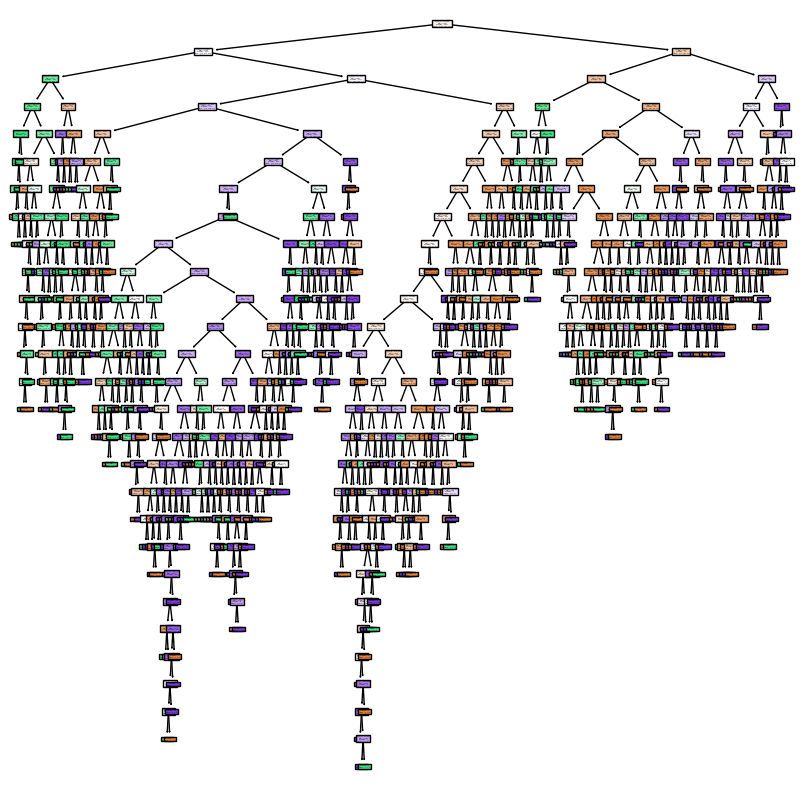

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn import tree  # Import the tree module
# Visualize the first tree in the random forest
tree_estimator = rf.estimators_[0]

plt.figure(figsize=(10, 10))
tree.plot_tree(tree_estimator, filled=True)
plt.show()

1/1 [==============================] - 0s 51ms/step
Hasilnya adalah  /content/PLD_3_Classes_256/Training/Late_Blight


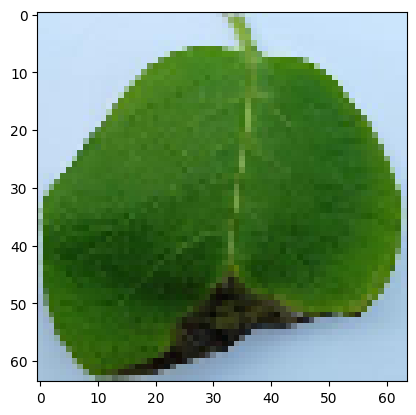

In [77]:
img_path_1 = "/content/PLD_3_Classes_256/Testing/Late_Blight/Late_Blight_40.jpg"
img_path_2 = "/content/PLD_3_Classes_256/Testing/Healthy/Healthy_41.jpg"
img_path_3 = "/content/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_27.jpg"

#Testing Image Late_Blight
img = cv2.imread(img_path_1, cv2.IMREAD_COLOR)
img = cv2.resize(img, (64, 64))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("Hasilnya adalah ",id_to_label[predictions[0]])

1/1 [==============================] - 0s 39ms/step
Hasilnya adalah  /content/PLD_3_Classes_256/Training/Healthy


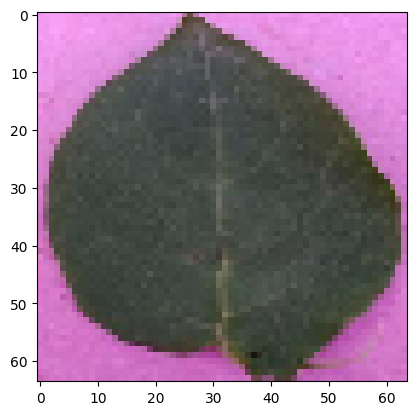

In [78]:
#Testing Image Healthy
img = cv2.imread(img_path_2, cv2.IMREAD_COLOR)
img = cv2.resize(img, (64, 64))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("Hasilnya adalah ",id_to_label[predictions[0]])

1/1 [==============================] - 0s 38ms/step
Hasilnya adalah  /content/PLD_3_Classes_256/Training/Early_Blight


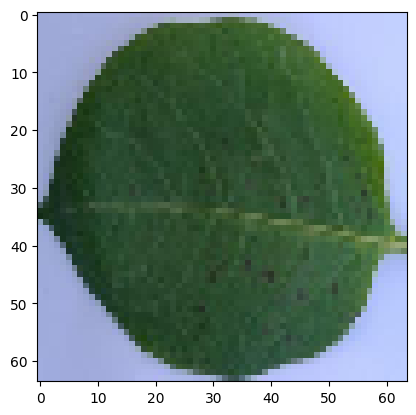

In [79]:
#Testing Image Early Blight
img = cv2.imread(img_path_3, cv2.IMREAD_COLOR)
img = cv2.resize(img, (64, 64))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("Hasilnya adalah ",id_to_label[predictions[0]])